<a href="https://colab.research.google.com/github/tianjianjiang/playground/blob/master/IMDb_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tianjianjiang/playground/blob/master/notebooks/IMDb_baseline.ipynb)

# Prepare

## References
* [fastai/course-v3/nbs/dl1/lesson3-imdb.ipynb](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb) (2019-05-03)

learner|bs|lr  |bptt|wd  |drop_mult|`to_fp16(clip)`|fw acc%
--     |-:|--: |--: |--: |--:      |--             |--:
lm     |48|1e-2|70  |0.01|0.3      |No             |34.1371
cf     |48|2e-2|70  |0.01|0.5      |No             |94.3960

* [fastai/fastai/examples/ULMFit.ipynb](https://nbviewer.jupyter.org/github/fastai/fastai/blob/master/examples/ULMFit.ipynb) (2019-06-11)

  > Fine-tuning a forward and backward langauge model to get to 95.4% accuracy on the IMDB movie reviews dataset. This tutorial is done with fastai v1.0.53.

  > The example was run on a Titan RTX (24 GB of RAM) so you will probably need to adjust the batch size accordinly. If you divide it by 2, don't forget to divide the learning rate by 2 as well in the following cells. You can also reduce a little bit the bptt to gain a bit of memory.

learner|bs |lr  |bptt|wd  |drop_mult|`to_fp16(clip)`|fw acc%|bw acc%|avg acc%
--     |--:|--: |--: |--: |--:      |--             |--:    |--:    |--:
lm     |256|2e-2|  80|0.1 |1.0      |Yes; clip=0.1  |34.0075|37.2268|N/A
cf     |128|1e-1| 70†|0.1‡|0.5      |No             |94.9560|94.7400|95.39

    † both cf's used default bptt=70
    ‡ forward cf used default wd=0.01

* [fastai/course-nlp/nn-imdb-more.ipynb](https://nbviewer.jupyter.org/github/fastai/course-nlp/blob/master/nn-imdb-more.ipynb) (2019-06-12)

learner|bs |lr        |bptt|wd  |drop_mult|`to_fp16(clip)`|fw acc%
--     |--:|--:       |--: |--: |--:      |--             |--:
lm     |128|1e-2*bs/48|  70|0.01|1.0      |Yes; clip=None |>27.8265†
cf     |128|2e-2*bs/48|  70|0.01|0.5      |Yes; clip=None |94.8080

    † forward lm's final accuracy wasn't shown

In [0]:
# Ensure GPU spec; T4 is for colab and one can change it for another env.
gpu_list = !nvidia-smi -L
if gpu_list[0].startswith('NVIDIA-SMI has failed'):
  print('Runtime type should be GPU.')
elif not gpu_list[0].startswith('GPU 0: Tesla T4'):
  display(gpu_list)
  print('Please reset all runtimes. We need a Tesla T4 to reproduce the experiments!')
else:
  display(gpu_list)

## Dependency

### Install

In [0]:
# Ensure no surprises from conflict packages.
!pip check

In [0]:
%%capture pip_logs
!pip install -U fastai==1.0.57 ipyexperiments jupyter-console==5.2.0 coverage==4.5.3 coveralls datascience albumentations

In [0]:
# If package updates demands a restart, a colab_vnd generated button will show.
colab_vnd = 'application/vnd.colab-display-data+json'
for o in pip_logs.outputs:
  if colab_vnd in o.data and 'pip_warning' in o.data[colab_vnd]:
    o.display()
!pip check

### Import

In [0]:
import gc
import math
from pathlib import Path
import pickle
import random
from shutil import copytree
from typing import Optional, Tuple

import numpy as np
import torch
from google.colab import drive

from fastai import basic_data, basic_train, core
from fastai import *
from fastai.callbacks import CSVLogger, MixedPrecision
from fastai.core import plt
from fastai.text import *
from fastprogress import fastprogress

from ipyexperiments import *

### Init


In [0]:
# Not set earlier because pip may require a restart.
SESSN_START, = !date +%Y%m%dT%H%M

In [0]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_formats = {'png', 'retina'}

In [0]:
# Stylize the plot of `lr_find()`
plt.style.use(['dark_background','seaborn-poster','seaborn-deep'])
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'x'
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.color'] = 'xkcd:lime green'
plt.rcParams['grid.linestyle'] = ':'

In [0]:
# A special treatment for colab to decrease network traffic.
fastprogress.NO_BAR = True
master_bar, progress_bar = fastprogress.force_console_behavior()
basic_train.master_bar, basic_train.progress_bar = master_bar, progress_bar
basic_data.master_bar, basic_data.progress_bar = master_bar, progress_bar
dataclass.master_bar, dataclass.progress_bar = master_bar, progress_bar
text.master_bar, text.progress_bar = master_bar, progress_bar
text.data.master_bar, text.data.progress_bar = master_bar, progress_bar
core.master_bar, core.progress_bar = master_bar, progress_bar

In [0]:
COLAB_CONTENT_DIR = Path('/content')
GD_DIR = COLAB_CONTENT_DIR / 'gdrive'
drive.mount(str(GD_DIR), force_remount=True)

In [0]:
CORPUS = 'imdb'
BASE_DIR = GD_DIR / 'My Drive' / CORPUS
BASE_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)
MDLS_DIR = BASE_DIR / 'models'
MDLS_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR = BASE_DIR / 'logs'
LOGS_DIR.mkdir(parents=True, exist_ok=True)

FASTAI_DATA_DIR = Path('/root/.fastai/data')
FASTAI_DATA_DIR.mkdir(parents=True, exist_ok=True)
COLAB_DATA_DIR = COLAB_CONTENT_DIR / 'data'
if not COLAB_DATA_DIR.is_symlink():
  COLAB_DATA_DIR.symlink_to(FASTAI_DATA_DIR)
if (COLAB_CONTENT_DIR / 'sample_data').exists():
  !rm -rf /content/sample_data/

CORPUS_IN_COLAB_DATA_DIR = COLAB_DATA_DIR / CORPUS

In [0]:
downloaded_corpus_dir = untar_data(URLs.IMDB, dest=COLAB_DATA_DIR)
assert downloaded_corpus_dir == CORPUS_IN_COLAB_DATA_DIR

# Assign

In [0]:
#@title Hyper-parameters

lm_bs = 64  #@param {type: "number"}
cf_bs = 64  #@param {type: "number"}
bptt = 70  #@param {type: "number"}
moms = (0.8, 0.7)  #@param

REFERRED_LM_LR = 1e-2 * lm_bs / 48
REFERRED_CF_LR = 2e-2 * cf_bs / 48

#@markdown ---

lm_wd = 0.01  #@param {type: "number"}
cf_wd = 0.01  #@param {type: "number"}
lm_drop_mult = 1.0  #@param {type: "number"}
cf_drop_mult = 0.5  #@param {type: "number"}

FW_LM_DBNCH_FNAME = f'fw_lm_dbnch-b{lm_bs}-bptt{bptt}.pkl'
FW_CF_DBNCH_FNAME = f'fw_cf_dbnch-b{cf_bs}-bptt{bptt}.pkl'

VOCAB_FILE = DATA_DIR / f'imdb_vocab.pkl'

In [0]:
IMDB_CLASSES = ['neg', 'pos']

In [0]:
# Set num_workers to main process since the training set will be shuffled.
N_DBNCH_WRKRS = 0

In [0]:
# One seed to rule pseudo-random number generators all.
SEED = 42

# Define

All those helpers are for demonstration. Ideal implementations would be decorators or callbacks.

However, although fastai prefers callbacks, the order of callback invocations will be another issue.

## PRNG State Fixer

In [0]:
@dataclass
class PseudoRandomStatesHolder:
  py3_state: Tuple[int, Tuple[int], Optional[float]]
  np_state: Tuple[str, np.ndarray, int, int, float]
  torch_state: torch.ByteTensor
  cuda_states: List[torch.ByteTensor]

In [0]:
# fastai v1.0.57 does something similar but it won't suffice.
def reset_prng_states(seed=SEED):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)  # This implies torch.cuda.manual_seed_all(SEED) now
  # if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True  # About 15% slower but...
  torch.backends.cudnn.benchmark = False

In [0]:
def get_prng_states():
  prng_states = PseudoRandomStatesHolder(random.getstate(),
                                         np.random.get_state(),
                                         torch.get_rng_state(),
                                         torch.cuda.get_rng_state_all())
  # print(f'Got prng_states:\n'
  #       f'  py3:   {prng_states.py3_state}\n'
  #       f'  np:    {prng_states.np_state}\n'
  #       f'  torch: {prng_states.torch_state}\n'
  #       f'  cuda:  {prng_states.cuda_states}')
  return prng_states

In [0]:
def set_prng_states(prng_states: PseudoRandomStatesHolder):
  random.setstate(prng_states.py3_state)
  np.random.set_state(prng_states.np_state)
  torch.set_rng_state(prng_states.torch_state)
  torch.cuda.set_rng_state_all(prng_states.cuda_states)
  # print(f'Set prng_states:\n'
  #       f'  py3:   {prng_states.py3_state}\n'
  #       f'  np:    {prng_states.np_state}\n'
  #       f'  torch: {prng_states.torch_state}\n'
  #       f'  cuda:  {prng_states.cuda_states}')

In [0]:
def save_prng_states(name, prng_states, data_dir=DATA_DIR):
  prng_states_pkl_path = data_dir / f'ps-{name}.pkl'
  with open(prng_states_pkl_path, 'wb') as f:
    pickle.dump(prng_states, f)

In [0]:
def load_prng_states(name, data_dir=DATA_DIR):
  prng_states_pkl_path = data_dir / f'ps-{name}.pkl'
  if (prng_states_pkl_path.exists() and prng_states_pkl_path.is_file()):
    with open(prng_states_pkl_path, 'rb') as f:
      prng_states = pickle.load(f)
      return prng_states
  else:
    raise FileNotFoundError(f'No {prng_states_pkl_path} to load!')

## Checkpoint Helpers

In [0]:
@dataclass
class Checkpoint:
  name: str
  frozen_to: int
  mp_loss_scale: float

In [0]:
def preserve_event(name, learner, frozen_to=-1, data_dir=DATA_DIR):
  save_prng_states(name, get_prng_states())

  learner.save(name, with_opt=True)

  mp_loss_scale = None
  for i, cb in enumerate(learner.callbacks):
    if isinstance(cb, MixedPrecision):
      print(f'Found MixedPrecision loss_scale={cb.loss_scale}')
      mp_loss_scale = cb.loss_scale
      break

  checkpoint = Checkpoint(name, frozen_to, mp_loss_scale)
  checkpoint_fpath = data_dir / f'cp-{name}.pkl'
  with open(checkpoint_fpath, 'wb') as f:
    pickle.dump(checkpoint, f)
    print(f'{checkpoint} saved to {checkpoint_fpath}')

In [0]:
def retain_event(name, learner, data_dir=DATA_DIR):
  if name is None:
    reset_prng_states()
  else:
    set_prng_states(load_prng_states(name))

  checkpoint_fpath = data_dir / f'cp-{name}.pkl'
  if not (checkpoint_fpath.exists() and checkpoint_fpath.is_file()):
    print(f'No {checkpoint_fpath} to load!')
    return learner
  with open(checkpoint_fpath, 'rb') as f:
    checkpoint = pickle.load(f)
    print(f'{checkpoint} loaded from {checkpoint_fpath}')

    learner.freeze_to(checkpoint.frozen_to)  # This must be before `load()`.
    print(f'Frozen to {checkpoint.frozen_to}')

    learner = learner.load(checkpoint.name, with_opt=True)

    if checkpoint.mp_loss_scale:
      for i, cb in enumerate(learner.callbacks):
        if isinstance(cb, MixedPrecision):
          learner.callbacks[i].loss_scale = checkpoint.mp_loss_scale
          print('Retained MixedPrecision loss_scale='
                f'{learner.callbacks[i].loss_scale}')
          break

    return learner

In [0]:
def fit_a_named_cycle(name, learner, lrs, moms, wd, clbks, cyc_len, freeze_to,
                      prev_event_name):
  for i, cb in enumerate(learner.callbacks):
    if isinstance(cb, MixedPrecision):
      print(f'Found MixedPrecision loss_scale={cb.loss_scale}')
  learner = retain_event(prev_event_name, learner)

  # `unfreeze()` does just `freeze_to(0)`
  # `freeze()` does `freeze_to(-1)` with a size-assertion of layer groups
  learner.freeze_to(freeze_to)
  learner.fit_one_cycle(cyc_len=cyc_len, max_lr=lrs, moms=moms, wd=wd,
                        callbacks=clbks)

  preserve_event(name, learner, freeze_to)

  return learner

## LM-specific Helpers

In [0]:
def set_lm_databunch(fname, bs, bptt, seed=SEED, presort=True,
                     n_wrkrs=N_DBNCH_WRKRS, data_dir=DATA_DIR,
                     raw_data_dir=CORPUS_IN_COLAB_DATA_DIR):
  reset_prng_states()
  tl = TextList.from_folder(raw_data_dir, presort=presort)
  il = tl.filter_by_folder(include=['train', 'test', 'unsup'])
  ils = il.split_by_rand_pct(0.1, seed)  # Set the seed again since in theory one may have called np.random before this.
  lls = ils.label_for_lm()
  dbnch = lls.databunch(bs=bs, bptt=bptt, num_workers=n_wrkrs)
  dbnch.save(data_dir / fname)
  return dbnch

In [0]:
def get_lm_databunch(fname, bs, bptt, backwards=False, n_wrkrs=N_DBNCH_WRKRS,
                     data_dir=DATA_DIR):
  reset_prng_states()
  return load_data(data_dir, fname, bs, num_workers=n_wrkrs,
                   backwards=backwards, bptt=bptt)

In [0]:
def new_lm_learner_with_ulmfit(name, dbnch, drop_mult, base_dir=BASE_DIR):
  reset_prng_states()
  lrnr = language_model_learner(dbnch, AWD_LSTM, drop_mult=drop_mult,
                                path=base_dir)
  # lrnr = lrnr.to_fp16(clip=0.1)  # 2x faster
  lrnr = lrnr.to_fp16()  # 2x faster
  save_prng_states(name, get_prng_states())
  return lrnr

## CF-specific Helpers

In [0]:
def set_cf_databunch(fname, bs, vocab, tags=IMDB_CLASSES, presort=True,
                     n_wrkrs=N_DBNCH_WRKRS, data_dir=DATA_DIR,
                     raw_data_dir=CORPUS_IN_COLAB_DATA_DIR):
  reset_prng_states()
  tl = TextList.from_folder(raw_data_dir, vocab=vocab, presort=presort)
  ils = tl.split_by_folder(valid='test')
  lls = ils.label_from_folder(classes=tags)
  dbnch = lls.databunch(bs=bs, num_workers=n_wrkrs)
  dbnch.save(data_dir / fname)
  return dbnch

In [0]:
def get_cf_databunch(fname, bs, backwards=False, n_wrkrs=N_DBNCH_WRKRS,
                     data_dir=DATA_DIR):
  reset_prng_states()
  return load_data(data_dir, fname, bs, num_workers=n_wrkrs,
                   backwards=backwards)

In [0]:
def new_cf_learner_with_encoder(name, dbnch, drop_mult, enc_name, bptt,
                                base_dir=BASE_DIR):
  reset_prng_states()
  lrnr = text_classifier_learner(dbnch, AWD_LSTM, drop_mult=drop_mult,
                                 path=base_dir, bptt=bptt, pretrained=False)
  lrnr = lrnr.to_fp16()
  lrnr = lrnr.load_encoder(enc_name)
  save_prng_states(name, get_prng_states())
  return lrnr

# Fit

## Forward LM

### Process Data Once

In [0]:
if not (DATA_DIR / FW_LM_DBNCH_FNAME).exists():
  fw_lm_dbnch = set_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt)
  print(f'Built and saved {DATA_DIR / FW_LM_DBNCH_FNAME}')
  # fw_lm_dbnch.show_batch()
  if not VOCAB_FILE.exists():
    fw_lm_dbnch.vocab.save(VOCAB_FILE)
    print(f'Saved {VOCAB_FILE}')

# fw_lm_dbnch = get_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt)
# print(f'Loaded {DATA_DIR / FW_LM_DBNCH_FNAME}')
# fw_lm_dbnch.show_batch()
# IMDB_VOC = Vocab.load(VOCAB_FILE)
# print(f'Loaded {VOCAB_FILE}')

### Find Learning Rate

I use a different method to approximate a good learning rate.

In [0]:
%%capture lm_lr_find_scope_begin_log
lm_lr_find_scope = IPyExperimentsPytorch(cl_enable=False)

In [0]:
fw_lm_dbnch = get_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt)
assert fw_lm_dbnch.train_dl.batch_size == lm_bs
lm_epoch_sz = math.ceil(len(fw_lm_dbnch.train_ds) / lm_bs)
ratio = 4 / 5
epoch_scale = ratio * 0.3  # OneCycleScheduler's pct_start=0.3
lm_num_it = math.ceil(lm_epoch_sz * epoch_scale)
print(
    f'lm_epoch_sz = {lm_epoch_sz}\n'
    f'lm_num_it   = {lm_num_it}')

lm_epoch_sz = 1407
lm_num_it   = 338


In [0]:
fw_lm_lrnr = new_lm_learner_with_ulmfit('new-fw_lm', fw_lm_dbnch, lm_drop_mult)
fw_lm_lrnr.path = COLAB_DATA_DIR

In [0]:
start_lr = 4.5e-4
end_lr = round(start_lr * 20, 3)
fw_lm_lrnr.lr_find(start_lr, end_lr, lm_num_it, wd=lm_wd)
min_loss = np.min(fw_lm_lrnr.recorder.losses)
min_loss_it = np.argmin(fw_lm_lrnr.recorder.losses) + 1
end_loss = fw_lm_lrnr.recorder.losses[-1].item()
print(f'lr range = [{start_lr}, {end_lr}]\n'
      f'min_loss = {min_loss} @ {min_loss_it}\n'
      f'end_loss = {end_loss} @ {lm_num_it}')

epoch     train_loss  valid_loss  accuracy  time    
0         4.593526    #na#        00:55     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
lr range = [0.00045, 0.009]
min_loss = 4.593526363372803 @ 338
end_loss = 4.593526363372803 @ 338


In [0]:
%%capture lm_lr_find_log
fw_lm_lrnr.recorder.plot(skip_start=0, skip_end=0, suggestion=True)

Min numerical gradient: 4.58E-04
Min loss divided by 10: 8.92E-04


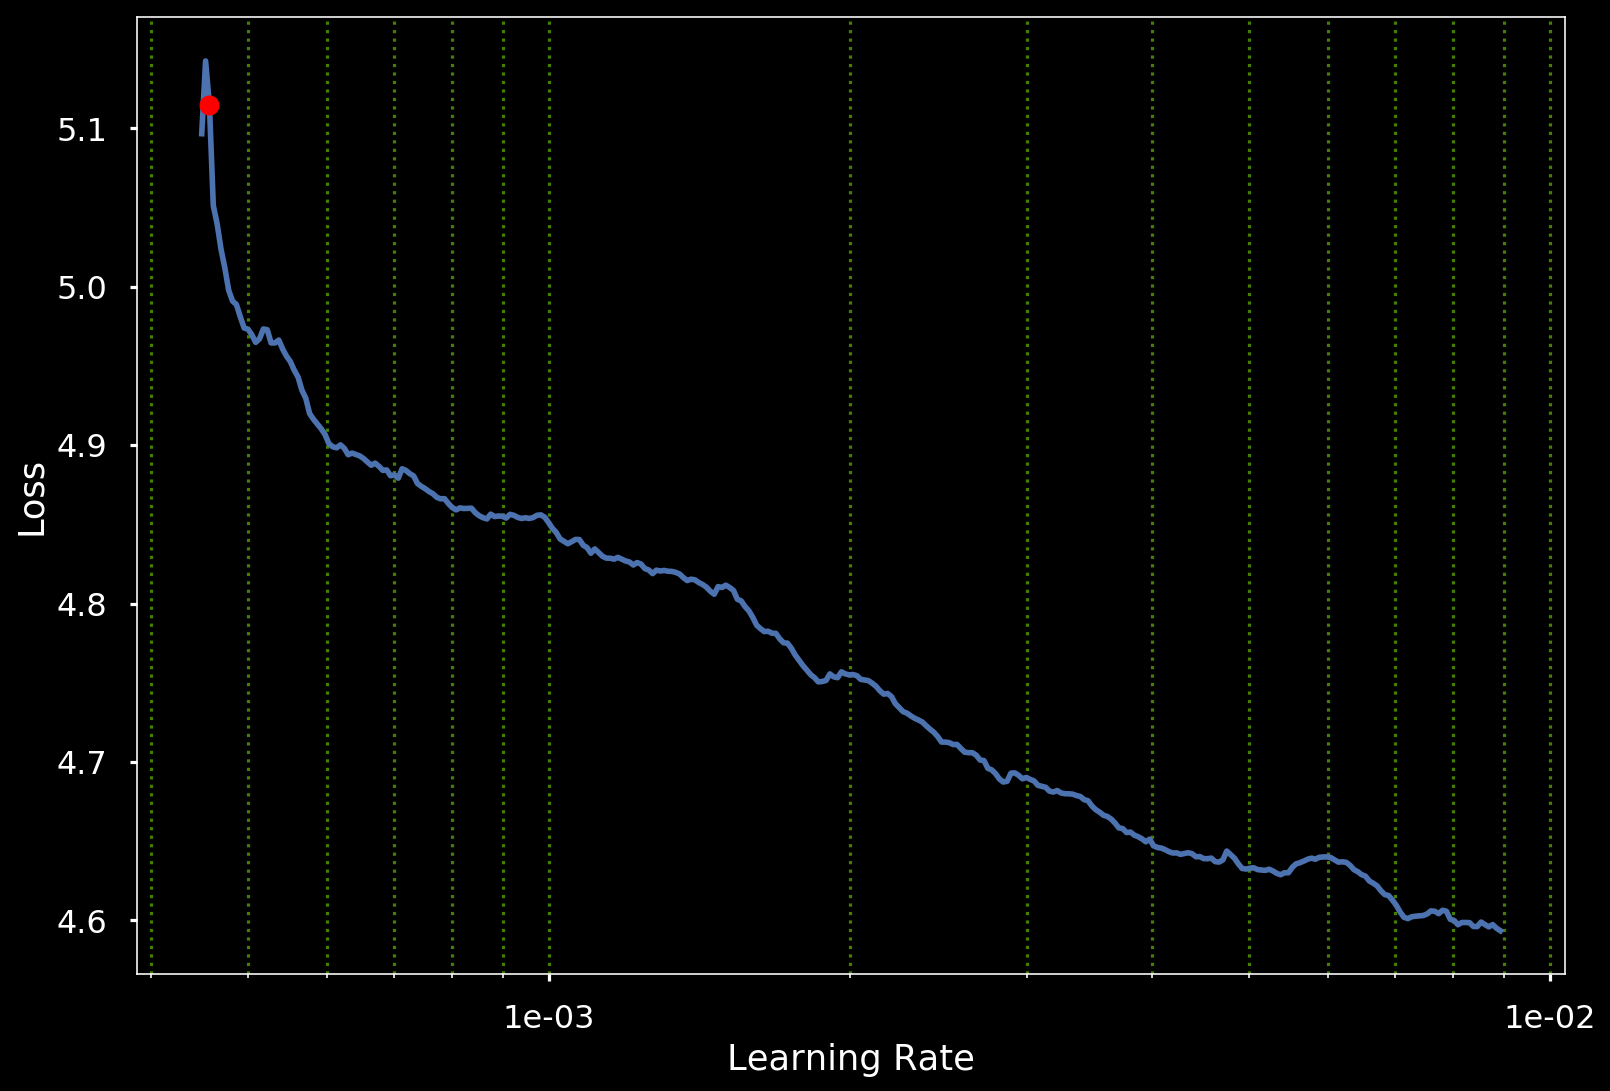

In [0]:
lm_lr_find_log()

In [0]:
lm_min_grad_lr = fw_lm_lrnr.recorder.min_grad_lr
lm_min_loss_lr = fw_lm_lrnr.recorder.lrs[np.argmin(fw_lm_lrnr.recorder.losses)]
((_, lm_min_grad_lr_str),
 (_, lm_min_loss_lr_dv10_str)
 ) = [line.split(': ') for line in lm_lr_find_log.stdout.split('\n') if line]
assert f'{lm_min_grad_lr:.2E}' == lm_min_grad_lr_str
assert f'{lm_min_loss_lr/10:.2E}' == lm_min_loss_lr_dv10_str
(fw_lm_lrnr.path/fw_lm_lrnr.model_dir/'tmp.pth').unlink()

In [0]:
scale = min_loss_it / lm_num_it
my_guess1_lm_lr = lm_min_loss_lr / (ratio * scale)
my_guess2_lm_lr = start_lr * scale * 25
print(
    f'referred  lm_lr = {REFERRED_LM_LR}\n'
    f'min grad. lm_lr = {lm_min_grad_lr}\n'
    f'min loss  lm_lr = {lm_min_loss_lr}\n'
    f'my guess1 lm_lr = {my_guess1_lm_lr}\n'
    f'my guess2 lm_lr = {my_guess2_lm_lr}')

referred  lm_lr = 0.013333333333333334
min grad. lm_lr = 0.0004580479208121953
min loss  lm_lr = 0.00892058443532486
my guess1 lm_lr = 0.011150730544156074
my guess2 lm_lr = 0.01125


In [0]:
%%capture lm_lr_find_scope_end_log
lm_lr_find_scope.keep_var_names('my_guess1_lm_lr', 'my_guess2_lm_lr')
del lm_lr_find_scope; gc.collect()

### Init-fit

There will be many redundant variable assignments.

That is how I indicate the messy global states of a Jupyter notebook.

Watch [I don't like notebooks]( https://www.youtube.com/watch?v=7jiPeIFXb6U) for details.

In [0]:
lm_lr = 0.01  # round(my_guess2_lm_lr, 2)
init_fw_lm_name = f'init_fw_lm-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
print(f'designated lm_lr = {lm_lr}')

In [0]:
%%capture init_fw_lm_scope_begin_log
init_fw_lm_scope = IPyExperimentsPytorch(cl_enable=False)
fw_lm_dbnch = get_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt)
fw_lm_lrnr = new_lm_learner_with_ulmfit('new-fw_lm', fw_lm_dbnch, lm_drop_mult)

In [0]:
print(init_fw_lm_name)
init_fw_lm_log_name = LOGS_DIR / f'{SESSN_START}-{init_fw_lm_name}'  # w/o .csv
init_fw_lm_clbks = [CSVLogger(fw_lm_lrnr, init_fw_lm_log_name, True)]
fw_lm_lrnr = fit_a_named_cycle(init_fw_lm_name, fw_lm_lrnr, lm_lr, moms, lm_wd,
                               init_fw_lm_clbks, cyc_len=1, freeze_to=-1,
                               prev_event_name='new-fw_lm')
# init_fw_lm_lrnr.csv_logger.read_logged_file()
# (init_fw_lm_lrnr.path / init_fw_lm_lrnr.model_dir).ls()

init_fw_lm-b64-bptt70-lr0.01115
Found init. loss_scale=65536
No /content/gdrive/My Drive/imdb/data/cp-new-fw_lm.pkl to load!
epoch     train_loss  valid_loss  accuracy  time    
0         4.433111    4.068985    0.289440  17:41     
Found MixedPrecision loss_scale=1048576.0
Checkpoint(name='init_fw_lm-b64-bptt70-lr0.01115', frozen_to=-1, mp_loss_scale=1048576.0) saved to /content/gdrive/My Drive/imdb/data/cp-init_fw_lm-b64-bptt70-lr0.01115.pkl


In [0]:
%%capture init_fw_lm_scope_end_log
del init_fw_lm_scope
gc.collect()

### Fine-tune

In [0]:
lm_lr = 0.01125
init_fw_lm_name = f'init_fw_lm-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

finer_lm_lr = round(lm_lr / 10, 6)
tune_fw_lm_name = f'tune_fw_lm-b{lm_bs}-bptt{bptt}-lr{finer_lm_lr}'
print(f'designated finer_lm_lr = {finer_lm_lr}')

In [0]:
%%capture tune_fw_lm_scope_begin_log
tune_fw_lm_scope = IPyExperimentsPytorch(cl_enable=False)
fw_lm_dbnch = get_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt)
fw_lm_lrnr = new_lm_learner_with_ulmfit('new-fw_lm', fw_lm_dbnch, lm_drop_mult)

In [0]:
print(tune_fw_lm_name)
tune_fw_lm_log_name = LOGS_DIR / f'{SESSN_START}-{tune_fw_lm_name}'
tune_fw_lm_clbks = [CSVLogger(fw_lm_lrnr, tune_fw_lm_log_name, True)]
fw_lm_lrnr = fit_a_named_cycle(tune_fw_lm_name, fw_lm_lrnr, finer_lm_lr, moms,
                               lm_wd, tune_fw_lm_clbks, cyc_len=10, freeze_to=0,
                               prev_event_name=init_fw_lm_name)
fw_lm_lrnr.save_encoder(fw_enc_name)

tune_fw_lm-b64-bptt70-lr0.001125
Found init. loss_scale=65536
Checkpoint(name='init_fw_lm-b64-bptt70-lr0.01125', frozen_to=-1, mp_loss_scale=1048576.0) loaded from /content/gdrive/My Drive/imdb/data/cp-init_fw_lm-b64-bptt70-lr0.01125.pkl
Frozen to -1
Retained mb_loss_scale=1048576.0
epoch     train_loss  valid_loss  accuracy  time    
0         4.081573    3.880682    0.309587  19:51     
1         4.002107    3.815079    0.318992  19:51     
2         3.955130    3.776459    0.323981  19:50     
3         3.912738    3.736360    0.328587  19:51     
4         3.862216    3.704691    0.332078  19:50     
5         3.812183    3.673317    0.335519  19:51     
6         3.772932    3.647537    0.338416  19:52     
7         3.742402    3.628718    0.340383  19:52     
8         3.704498    3.618565    0.341570  19:50     
9         3.674266    3.616389    0.341848  19:50     
Found MixedPrecision loss_scale=2097152.0
Checkpoint(name='tune_fw_lm-b64-bptt70-lr0.001125', frozen_to=0, mp_los

In [0]:
%%capture tune_fw_lm_scope_end_log
del tune_fw_lm_scope
gc.collect()

## Forward CF

### Process Data Once

In [0]:
if not (DATA_DIR / FW_CF_DBNCH_FNAME).exists():
  IMDB_VOC = Vocab.load(VOCAB_FILE)
  print(f'Loaded {VOCAB_FILE}')
  fw_cf_dbnch = set_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs, IMDB_VOC)
  print(f'Built and saved {DATA_DIR / FW_CF_DBNCH_FNAME}')

# fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
# print(f'Loaded {DATA_DIR / FW_CF_DBNCH_FNAME}')

### Find Learning Rate

In [0]:
%%capture cf_lr_find_scope_begin_log
cf_lr_find_scope = IPyExperimentsPytorch(cl_enable=False)

In [0]:
fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
assert fw_cf_dbnch.train_dl.batch_size == cf_bs
cf_epoch_sz = math.ceil(len(fw_cf_dbnch.train_ds) / cf_bs)
ratio = 4 / 5
epoch_scale = ratio * 0.3
cf_num_it = math.ceil(cf_epoch_sz * epoch_scale)
print(
    f'cf_epoch_sz = {cf_epoch_sz}\n'
    f'cf_num_it   = {cf_num_it}')

cf_epoch_sz = 391
cf_num_it   = 94


In [0]:
lm_lr = 0.01125
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
fw_cf_lrnr = new_cf_learner_with_encoder('new-fw_cf', fw_cf_dbnch, cf_drop_mult,
                                         fw_enc_name, bptt)
fw_cf_lrnr.path = COLAB_DATA_DIR

In [0]:
start_lr = 4e-3
end_lr = round(start_lr * 20, 3)
fw_cf_lrnr.lr_find(start_lr, end_lr, cf_num_it, wd=cf_wd)
min_loss = np.min(fw_cf_lrnr.recorder.losses)
min_loss_it = np.argmin(fw_cf_lrnr.recorder.losses) + 1
end_loss = fw_cf_lrnr.recorder.losses[-1].item()
print(f'lr range = [{start_lr}, {end_lr}]\n'
      f'min_loss = {min_loss} @ {min_loss_it}\n'
      f'end_loss = {end_loss} @ {cf_num_it}')

epoch     train_loss  valid_loss  accuracy  time    
0         0.291489    #na#        00:13     
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
lr range = [0.004, 0.08]
min_loss = 0.27702632546424866 @ 68
end_loss = 0.29148927330970764 @ 94


In [0]:
%%capture cf_lr_find_log
fw_cf_lrnr.recorder.plot(skip_start=0, skip_end=0, suggestion=True)

Min numerical gradient: 4.26E-03
Min loss divided by 10: 3.38E-03


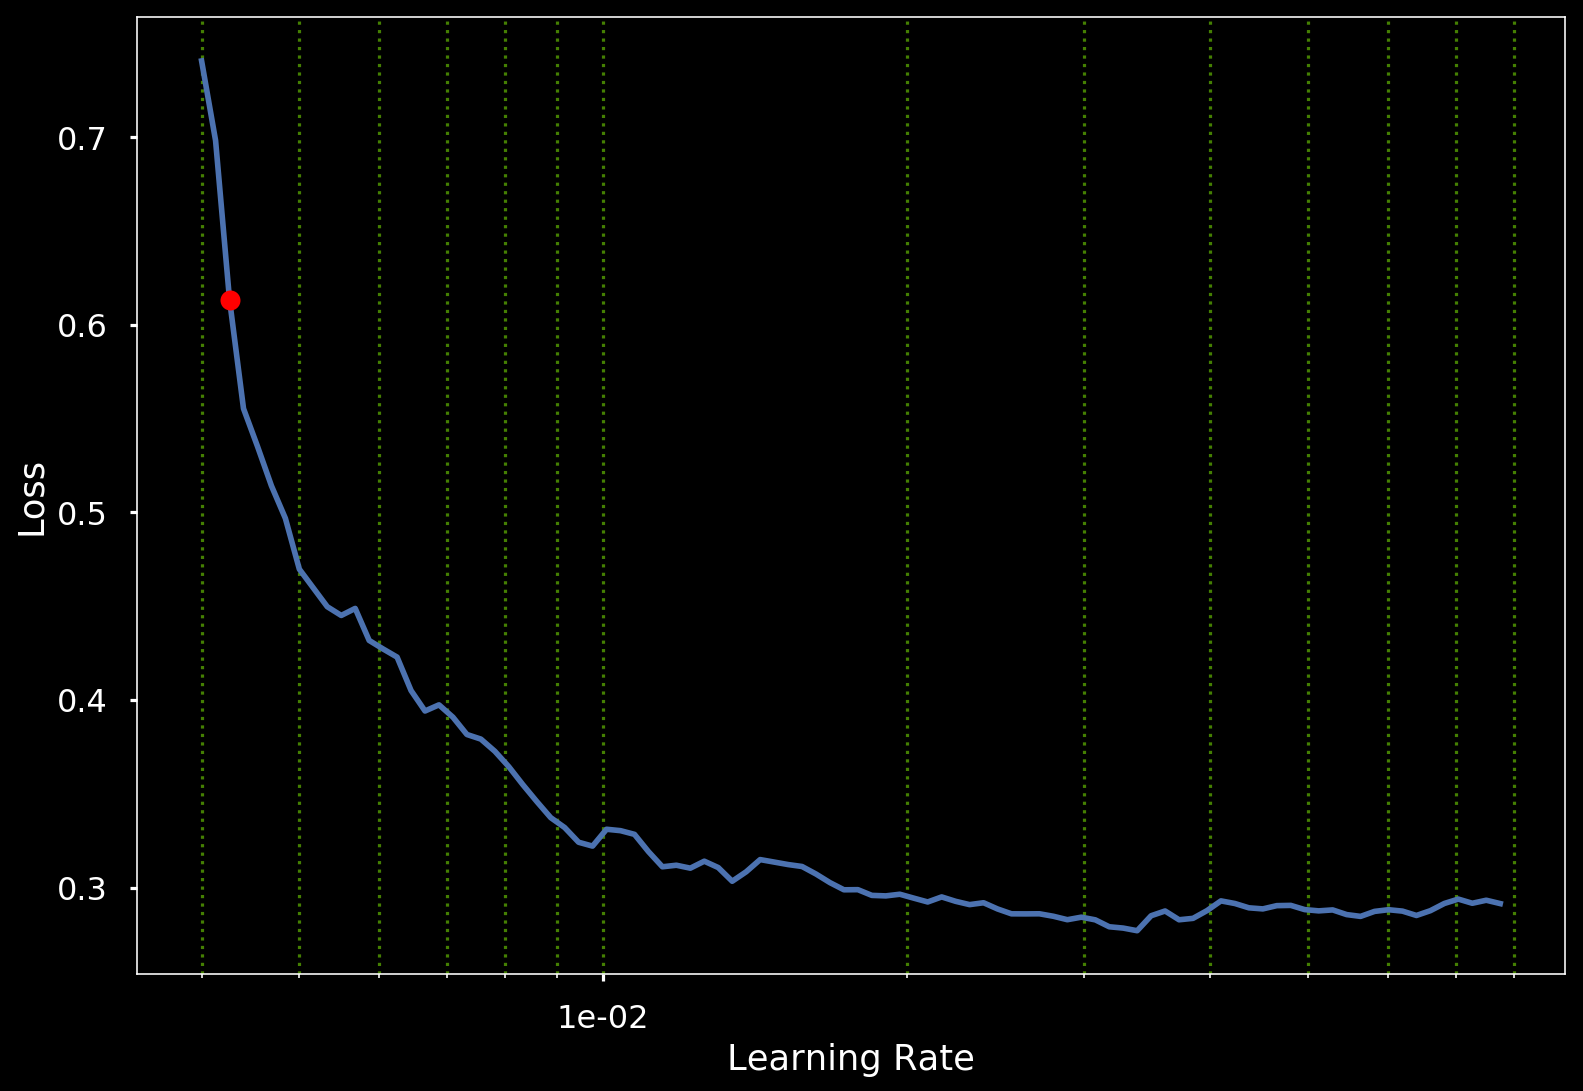

In [0]:
cf_lr_find_log()

In [0]:
cf_min_grad_lr = fw_cf_lrnr.recorder.min_grad_lr
cf_min_loss_lr = fw_cf_lrnr.recorder.lrs[np.argmin(fw_cf_lrnr.recorder.losses)]
((_, cf_min_grad_lr_str),
 (_, cf_min_loss_lr_dv10_str)
 ) = [line.split(': ') for line in cf_lr_find_log.stdout.split('\n') if line]
assert f'{cf_min_grad_lr:.2E}' == cf_min_grad_lr_str
assert f'{cf_min_loss_lr/10:.2E}' == cf_min_loss_lr_dv10_str
(fw_cf_lrnr.path/fw_cf_lrnr.model_dir/'tmp.pth').unlink()

In [0]:
scale = min_loss_it / cf_num_it
my_guess1_cf_lr = cf_min_loss_lr / (ratio * scale)
my_guess2_cf_lr = start_lr * scale * 25
print(
    f'referred  cf_lr = {REFERRED_CF_LR}\n'
    f'min grad. cf_lr = {cf_min_grad_lr}\n'
    f'min loss  cf_lr = {cf_min_loss_lr}\n'
    f'my guess1 cf_lr = {my_guess1_cf_lr}\n'
    f'my guess2 cf_lr = {my_guess2_cf_lr}')

referred  cf_lr = 0.02666666666666667
min grad. cf_lr = 0.0042632566739214724
min loss  cf_lr = 0.03383684654982418
my guess1 cf_lr = 0.05846808043535796
my guess2 cf_lr = 0.0723404255319149


In [0]:
%%capture cf_lr_find_scope_end_log
cf_lr_find_scope.keep_var_names('my_guess1_cf_lr', 'my_guess2_cf_lr')
del cf_lr_find_scope; gc.collect()

### Init-fit

In [0]:
lm_lr = 0.01125
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
init_fw_cf_name = f'init_fw_cf-b{cf_bs}-bptt{bptt}-lr{cf_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
print(f'designated cf_lr={cf_lr}')

designated cf_lr=0.07234


In [0]:
%%capture init_fw_cf_scope_begin_log
init_fw_cf_scope = IPyExperimentsPytorch(cl_enable=False)
fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
fw_cf_lrnr = new_cf_learner_with_encoder('new-fw_cf', fw_cf_dbnch, cf_drop_mult,
                                         fw_enc_name, bptt)

In [0]:
print(init_fw_cf_name)
init_fw_cf_log_name = LOGS_DIR / f'{SESSN_START}-{init_fw_cf_name}'
init_fw_cf_clbks = [CSVLogger(fw_cf_lrnr, init_fw_cf_log_name, True)]
fw_cf_lrnr = fit_a_named_cycle(init_fw_cf_name, fw_cf_lrnr, cf_lr, moms, cf_wd,
                               init_fw_cf_clbks, cyc_len=1, freeze_to=-1,
                               prev_event_name='new-fw_cf')

init_fw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125
Found init. loss_scale=65536
No /content/gdrive/My Drive/imdb/data/cp-new-fw_cf.pkl to load!
epoch     train_loss  valid_loss  accuracy  time    
0         0.237411    0.180904    0.931880  01:38     
Found MixedPrecision loss_scale=65536
Checkpoint(name='init_fw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=-1, mp_loss_scale=65536) saved to /content/gdrive/My Drive/imdb/data/cp-init_fw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl


In [0]:
%%capture init_fw_cf_scope_end_log
del init_fw_cf_scope; gc.collect()

### Fine-tune

#### Act-1

In [0]:
lm_lr = 0.01125
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
init_fw_cf_name = f'init_fw_cf-b{cf_bs}-bptt{bptt}-lr{cf_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

finer_cf_1_lr = cf_lr / 2
finer_cf_1_lrs = slice(finer_cf_1_lr / (2.6 ** 4), finer_cf_1_lr)
tune_fw_cf_1_name = f'tune_fw_cf-b{cf_bs}-bptt{bptt}-lr{finer_cf_1_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
print(f'designated finer_cf_lr={finer_cf_1_lr}')

designated finer_cf_lr=0.03617


In [0]:
%%capture tune_fw_cf_1_scope_begin_log
tune_fw_cf_1_scope = IPyExperimentsPytorch(cl_enable=False)
fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
fw_cf_lrnr = new_cf_learner_with_encoder('new-fw_cf', fw_cf_dbnch, cf_drop_mult,
                                         fw_enc_name, bptt)

In [0]:
print(tune_fw_cf_1_name)
tune_fw_cf_1_log_name = LOGS_DIR / f'{SESSN_START}-{tune_fw_cf_1_name}'
tune_fw_cf_1_clbks = [CSVLogger(fw_cf_lrnr, tune_fw_cf_1_log_name, True)]
fw_cf_lrnr = fit_a_named_cycle(tune_fw_cf_1_name, fw_cf_lrnr, finer_cf_1_lrs,
                               moms, cf_wd, tune_fw_cf_1_clbks, cyc_len=1,
                               freeze_to=-2, prev_event_name=init_fw_cf_name)

tune_fw_cf-b64-bptt70-lr0.03617_enc-b64-bptt70-lr0.01125
Found init. loss_scale=65536
Checkpoint(name='init_fw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=-1, mp_loss_scale=65536) loaded from /content/gdrive/My Drive/imdb/data/cp-init_fw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl
Frozen to -1
Retained mb_loss_scale=65536
epoch     train_loss  valid_loss  accuracy  time    
0         0.195903    0.157349    0.942600  01:55     
Found MixedPrecision loss_scale=65536
Checkpoint(name='tune_fw_cf-b64-bptt70-lr0.03617_enc-b64-bptt70-lr0.01125', frozen_to=-2, mp_loss_scale=65536) saved to /content/gdrive/My Drive/imdb/data/cp-tune_fw_cf-b64-bptt70-lr0.03617_enc-b64-bptt70-lr0.01125.pkl


In [0]:
%%capture tune_fw_cf_1_scope_end_log
del tune_fw_cf_1_scope; gc.collect()

#### Act-2

In [0]:
lm_lr = 0.01125
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
finer_cf_1_lr = cf_lr / 2
tune_fw_cf_1_name = f'tune_fw_cf-b{cf_bs}-bptt{bptt}-lr{finer_cf_1_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

finer_cf_2_lr = cf_lr / (2 * 2)
finer_cf_2_lrs = slice(finer_cf_2_lr / (2.6 ** 4), finer_cf_2_lr)
tune_fw_cf_2_name = f'tune_fw_cf-b{cf_bs}-bptt{bptt}-lr{finer_cf_2_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
print(f'designated finer_cf_lr={finer_cf_2_lr}')

designated finer_cf_lr=0.018085


In [0]:
%%capture tune_fw_cf_2_scope_begin_log
tune_fw_cf_2_scope = IPyExperimentsPytorch(cl_enable=False)
fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
fw_cf_lrnr = new_cf_learner_with_encoder('new-fw_cf', fw_cf_dbnch, cf_drop_mult,
                                         fw_enc_name, bptt)

In [0]:
print(tune_fw_cf_2_name)
tune_fw_cf_2_log_name = LOGS_DIR / f'{SESSN_START}-{tune_fw_cf_2_name}'
tune_fw_cf_2_clbks = [CSVLogger(fw_cf_lrnr, tune_fw_cf_2_log_name, True)]
fw_cf_lrnr = fit_a_named_cycle(tune_fw_cf_2_name, fw_cf_lrnr, finer_cf_2_lrs,
                               moms, cf_wd, tune_fw_cf_2_clbks, cyc_len=1,
                               freeze_to=-3, prev_event_name=tune_fw_cf_1_name)

tune_fw_cf-b64-bptt70-lr0.018085_enc-b64-bptt70-lr0.01125
Found init. loss_scale=65536
Checkpoint(name='tune_fw_cf-b64-bptt70-lr0.03617_enc-b64-bptt70-lr0.01125', frozen_to=-2, mp_loss_scale=65536) loaded from /content/gdrive/My Drive/imdb/data/cp-tune_fw_cf-b64-bptt70-lr0.03617_enc-b64-bptt70-lr0.01125.pkl
Frozen to -2
Retained mb_loss_scale=65536
epoch     train_loss  valid_loss  accuracy  time    
0         0.180266    0.140276    0.948160  02:25     
Found MixedPrecision loss_scale=65536
Checkpoint(name='tune_fw_cf-b64-bptt70-lr0.018085_enc-b64-bptt70-lr0.01125', frozen_to=-3, mp_loss_scale=65536) saved to /content/gdrive/My Drive/imdb/data/cp-tune_fw_cf-b64-bptt70-lr0.018085_enc-b64-bptt70-lr0.01125.pkl


In [0]:
%%capture tune_fw_cf_2_scope_end_log
del tune_fw_cf_2_scope; gc.collect()

#### Act-3

In [0]:
lm_lr = 0.01125
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
finer_cf_2_lr = cf_lr / (2 * 2)
tune_fw_cf_2_name = f'tune_fw_cf-b{cf_bs}-bptt{bptt}-lr{finer_cf_2_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

finer_cf_3_lr = round(cf_lr / (2 * 2 * 5), 6)
finer_cf_3_lrs = slice(finer_cf_3_lr / (2.6 ** 4), finer_cf_3_lr)
tune_fw_cf_3_name = f'tune_fw_cf-b{cf_bs}-bptt{bptt}-lr{finer_cf_3_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
print(f'designated finer_cf_lr={finer_cf_3_lr}')

designated finer_cf_lr=0.003617


In [0]:
%%capture tune_fw_cf_3_scope_begin_log
tune_fw_cf_3_scope = IPyExperimentsPytorch(cl_enable=False)
fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
fw_cf_lrnr = new_cf_learner_with_encoder('new-fw_cf', fw_cf_dbnch, cf_drop_mult,
                                         fw_enc_name, bptt)

In [0]:
print(tune_fw_cf_3_name)
tune_fw_cf_3_log_name = LOGS_DIR / f'{SESSN_START}-{tune_fw_cf_3_name}'
tune_fw_cf_3_clbks = [CSVLogger(fw_cf_lrnr, tune_fw_cf_3_log_name, True)]
fw_cf_lrnr = fit_a_named_cycle(tune_fw_cf_3_name, fw_cf_lrnr, finer_cf_3_lrs,
                               moms, cf_wd, tune_fw_cf_3_clbks, cyc_len=2,
                               freeze_to=0, prev_event_name=tune_fw_cf_2_name)

tune_fw_cf-b64-bptt70-lr0.003617_enc-b64-bptt70-lr0.01125
Found init. loss_scale=65536
Checkpoint(name='tune_fw_cf-b64-bptt70-lr0.018085_enc-b64-bptt70-lr0.01125', frozen_to=-3, mp_loss_scale=65536) loaded from /content/gdrive/My Drive/imdb/data/cp-tune_fw_cf-b64-bptt70-lr0.018085_enc-b64-bptt70-lr0.01125.pkl
Frozen to -3
Retained mb_loss_scale=65536
epoch     train_loss  valid_loss  accuracy  time    
0         0.122708    0.151304    0.948120  02:49     
1         0.073715    0.153107    0.948840  03:03     
Found MixedPrecision loss_scale=32768.0
Checkpoint(name='tune_fw_cf-b64-bptt70-lr0.003617_enc-b64-bptt70-lr0.01125', frozen_to=0, mp_loss_scale=32768.0) saved to /content/gdrive/My Drive/imdb/data/cp-tune_fw_cf-b64-bptt70-lr0.003617_enc-b64-bptt70-lr0.01125.pkl


In [0]:
%%capture tune_fw_cf_3_scope_end_log
del tune_fw_cf_3_scope
gc.collect()

## Backward LM

In [0]:
if not (DATA_DIR / FW_LM_DBNCH_FNAME).exists():
  fw_lm_dbnch = set_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt)
  print(f'Built and saved {DATA_DIR / FW_LM_DBNCH_FNAME}')
  fw_lm_dbnch.vocab.save(VOCAB_FILE)
  print(f'Saved {VOCAB_FILE}')  

In [0]:
lm_lr = 0.01
init_bw_lm_name = f'init_bw_lm-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

In [0]:
%%capture init_lm_scope_begin_log
init_lm_scope = IPyExperimentsPytorch(cl_enable=False)
bw_lm_dbnch = get_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt, backwards=True)
bw_lm_lrnr = new_lm_learner_with_ulmfit('new-bw_lm', bw_lm_dbnch, lm_drop_mult)

In [0]:
print(init_bw_lm_name)
init_bw_lm_log_name = LOGS_DIR / f'{SESSN_START}-{init_bw_lm_name}'
init_bw_lm_clbks = [CSVLogger(bw_lm_lrnr, init_bw_lm_log_name, append=True)]
bw_lm_lrnr = fit_a_named_cycle(init_bw_lm_name, bw_lm_lrnr, lm_lr, moms, lm_wd,
                               init_bw_lm_clbks, cyc_len=1, freeze_to=-1,
                               prev_event_name='new-bw_lm')

init_bw_lm-b64-bptt70-lr0.01
Found init. loss_scale=65536
No /content/gdrive/My Drive/imdb/data/cp-new-bw_lm.pkl to load!
epoch     train_loss  valid_loss  accuracy  time    
0         4.430530    4.088774    0.323355  17:11     
Found MixedPrecision loss_scale=2097152.0
Checkpoint(name='init_bw_lm-b64-bptt70-lr0.01', frozen_to=-1, mp_loss_scale=2097152.0) saved to /content/gdrive/My Drive/imdb/data/cp-init_bw_lm-b64-bptt70-lr0.01.pkl


In [0]:
%%capture init_lm_scope_end_log
del init_lm_scope
gc.collect()

In [0]:
lm_lr = 0.01
init_bw_lm_name = f'init_bw_lm-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

bw_enc_name = f'bw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

tune_lm_lr = round(lm_lr/10, 6)
tune_bw_lm_name = f'tune_bw_lm-b{lm_bs}-bptt{bptt}-lr{tune_lm_lr}'
tune_lm_lr

0.001

In [0]:
%%capture tune_lm_scope_begin_log
tune_lm_scope = IPyExperimentsPytorch(cl_enable=False)
bw_lm_dbnch = get_lm_databunch(FW_LM_DBNCH_FNAME, lm_bs, bptt, backwards=True)
bw_lm_lrnr = new_lm_learner_with_ulmfit('new-bw_lm', bw_lm_dbnch, lm_drop_mult)

In [0]:
print(tune_bw_lm_name)
tune_bw_lm_log_name = LOGS_DIR / f'{SESSN_START}-{tune_bw_lm_name}'
tune_bw_lm_clbks = [CSVLogger(bw_lm_lrnr, tune_bw_lm_log_name, append=True)]
bw_lm_lrnr = fit_a_named_cycle(tune_bw_lm_name, bw_lm_lrnr, tune_lm_lr, moms,
                               lm_wd, tune_bw_lm_clbks, cyc_len=10, freeze_to=0,
                               prev_event_name=init_bw_lm_name)
bw_lm_lrnr.save_encoder(bw_enc_name)

tune_bw_lm-b64-bptt70-lr0.001
Found init. loss_scale=65536
Checkpoint(name='init_bw_lm-b64-bptt70-lr0.01', frozen_to=-1, mp_loss_scale=2097152.0) loaded from /content/gdrive/My Drive/imdb/data/cp-init_bw_lm-b64-bptt70-lr0.01.pkl
Frozen to -1
Retained mb_loss_scale=2097152.0
epoch     train_loss  valid_loss  accuracy  time    
0         4.139020    3.909299    0.342562  19:14     
1         4.023977    3.837232    0.351800  19:14     
2         3.993114    3.801412    0.356898  19:14     
3         3.927130    3.760121    0.361401  19:14     
4         3.902025    3.729016    0.364868  19:14     
5         3.840148    3.703532    0.367997  19:14     
6         3.799663    3.679397    0.370541  19:14     
7         3.751141    3.662572    0.372433  19:14     
8         3.744811    3.653554    0.373469  19:14     
9         3.711873    3.651567    0.373691  19:14     
Found MixedPrecision loss_scale=4194304.0
Checkpoint(name='tune_bw_lm-b64-bptt70-lr0.001', frozen_to=0, mp_loss_scale=4194

In [0]:
%%capture tune_lm_scope_end_log
del tune_lm_scope
gc.collect()

## Backward CF

In [0]:
lm_lr = 0.01125
bw_enc_name = f'bw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
init_bw_cf_name = f'init_bw_cf-b{cf_bs}-bptt{bptt}-lr{cf_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
print(f'designated cf_lr={cf_lr}')

designated cf_lr=0.07234


In [0]:
%%capture init_bw_cf_scope_begin_log
init_bw_cf_scope = IPyExperimentsPytorch(cl_enable=False)
bw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs, backwards=True)
bw_cf_lrnr = new_cf_learner_with_encoder('new-bw_cf', bw_cf_dbnch, cf_drop_mult,
                                         bw_enc_name, bptt)

In [0]:
print(init_bw_cf_name)
init_bw_cf_log_name = LOGS_DIR / f'{SESSN_START}-{init_bw_cf_name}'
init_bw_cf_clbks = [CSVLogger(bw_cf_lrnr, init_bw_cf_log_name, True)]
bw_cf_lrnr = fit_a_named_cycle(init_bw_cf_name, bw_cf_lrnr, cf_lr,
                                    moms, cf_wd, init_bw_cf_clbks, cyc_len=1,
                                    freeze_to=-1, prev_event_name='new-bw_cf')

init_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125
Found init. loss_scale=65536
No /content/gdrive/My Drive/imdb/data/cp-new-bw_cf.pkl to load!
epoch     train_loss  valid_loss  accuracy  time    
0         0.290525    0.214515    0.919880  01:38     
Found MixedPrecision loss_scale=65536
Checkpoint(name='init_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=-1, mp_loss_scale=65536) saved to /content/gdrive/My Drive/imdb/data/cp-init_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl


In [0]:
%%capture init_bw_cf_scope_end_log
del init_bw_cf_scope
gc.collect()

In [0]:
lm_lr = 0.01125
bw_enc_name = f'bw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
init_bw_cf_name = f'init_bw_cf-b{cf_bs}-bptt{bptt}-lr{cf_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'
tune_bw_cf_name = f'tune_bw_cf-b{cf_bs}-bptt{bptt}-lr{cf_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

In [0]:
%%capture tune_bw_cf_scope_begin_log
tune_bw_cf_scope = IPyExperimentsPytorch(cl_enable=False)
bw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs, backwards=True)
bw_cf_lrnr = new_cf_learner_with_encoder('new-bw_cf', bw_cf_dbnch, cf_drop_mult,
                                         bw_enc_name, bptt)

In [0]:
print(tune_bw_cf_name)
tune_bw_cf_log_name = LOGS_DIR / f'{SESSN_START}-{tune_bw_cf_name}'
tune_bw_cf_clbks = [CSVLogger(bw_cf_lrnr, tune_bw_cf_log_name, True)]

finer_cf_1_lr = cf_lr / 2
print(finer_cf_1_lr)
cf_lrs = slice(finer_cf_1_lr / (2.6 ** 4), finer_cf_1_lr)
bw_cf_lrnr = fit_a_named_cycle(tune_bw_cf_name, bw_cf_lrnr, cf_lrs, moms, cf_wd,
                               tune_bw_cf_clbks, cyc_len=1, freeze_to=-2,
                               prev_event_name=init_bw_cf_name)

finer_cf_2_lr = cf_lr / 2 / 2
print(finer_cf_2_lr)
cf_lrs = slice(finer_cf_2_lr / (2.6 ** 4), finer_cf_2_lr)
bw_cf_lrnr = fit_a_named_cycle(tune_bw_cf_name, bw_cf_lrnr, cf_lrs, moms, cf_wd,
                               tune_bw_cf_clbks, cyc_len=1, freeze_to=-3,
                               prev_event_name=tune_bw_cf_name)

finer_cf_3_lr = round(cf_lr / 2 / 2 / 5, 6)
print(finer_cf_3_lr)
cf_lrs = slice(finer_cf_3_lr / (2.6 ** 4), finer_cf_3_lr)
bw_cf_lrnr = fit_a_named_cycle(tune_bw_cf_name, bw_cf_lrnr, cf_lrs, moms, cf_wd,
                               tune_bw_cf_clbks, cyc_len=2, freeze_to=0,
                               prev_event_name=tune_bw_cf_name)

tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125
0.03617
Found init. loss_scale=65536
Checkpoint(name='init_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=-1, mp_loss_scale=65536) loaded from /content/gdrive/My Drive/imdb/data/cp-init_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl
Frozen to -1
Retained mb_loss_scale=65536
epoch     train_loss  valid_loss  accuracy  time    
0         0.210443    0.161169    0.942480  01:56     
Found MixedPrecision loss_scale=65536
Checkpoint(name='tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=-2, mp_loss_scale=65536) saved to /content/gdrive/My Drive/imdb/data/cp-tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl
0.018085
Found init. loss_scale=65536
Checkpoint(name='tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=-2, mp_loss_scale=65536) loaded from /content/gdrive/My Drive/imdb/data/cp-tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl
Frozen to -2
Reta

In [0]:
%%capture tune_bw_cf_scope_end_log
del tune_bw_cf_scope
gc.collect()

# Ensemble

In [0]:
lm_lr = 0.01125
fw_enc_name = f'fw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
finer_cf_3_lr = round(cf_lr / (2 * 2 * 5), 6)
tune_fw_cf_3_name = f'tune_fw_cf-b{cf_bs}-bptt{bptt}-lr{finer_cf_3_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

fw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs)
fw_cf_lrnr = new_cf_learner_with_encoder('new-fw_cf', fw_cf_dbnch, cf_drop_mult,
                                         fw_enc_name, bptt)

set_prng_states(load_prng_states(tune_fw_cf_3_name))
fw_cf_lrnr = retain_event(tune_fw_cf_3_name, fw_cf_lrnr)
fw_preds, tgt_lbls = fw_cf_lrnr.get_preds(ordered=True)
accuracy(fw_preds, tgt_lbls)

Checkpoint(name='tune_fw_cf-b64-bptt70-lr0.003617_enc-b64-bptt70-lr0.01125', frozen_to=0, mp_loss_scale=32768.0) loaded from /content/gdrive/My Drive/imdb/data/cp-tune_fw_cf-b64-bptt70-lr0.003617_enc-b64-bptt70-lr0.01125.pkl
Frozen to 0
Retained mb_loss_scale=32768.0


tensor(0.9488)

In [0]:
lm_lr = 0.01125
bw_enc_name = f'bw_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

cf_lr = 0.07234
tune_bw_cf_name = f'tune_bw_cf-b{cf_bs}-bptt{bptt}-lr{cf_lr}_enc-b{lm_bs}-bptt{bptt}-lr{lm_lr}'

bw_cf_dbnch = get_cf_databunch(FW_CF_DBNCH_FNAME, cf_bs, backwards=True)
bw_cf_lrnr = new_cf_learner_with_encoder('new-bw_cf', bw_cf_dbnch, cf_drop_mult,
                                         bw_enc_name, bptt)

set_prng_states(load_prng_states(tune_bw_cf_name))
bw_cf_lrnr = retain_event(tune_bw_cf_name, bw_cf_lrnr)

bw_preds, tgt_lbls = bw_cf_lrnr.get_preds(ordered=True)
accuracy(bw_preds, tgt_lbls)

Checkpoint(name='tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125', frozen_to=0, mp_loss_scale=16384.0) loaded from /content/gdrive/My Drive/imdb/data/cp-tune_bw_cf-b64-bptt70-lr0.07234_enc-b64-bptt70-lr0.01125.pkl
Frozen to 0
Retained mb_loss_scale=16384.0


tensor(0.9479)

In [0]:
print(f'lm_lr={lm_lr}\tcf_lr={cf_lr}')
avg_preds = (fw_preds + bw_preds) / 2
accuracy(avg_preds, tgt_lbls)

lm_lr=0.01125	cf_lr=0.07234


tensor(0.9545)